# <div style="text-align: right"> FIT1043 Introduction to Data Science<br>Assignment 2 </div>
<div style="text-align: right"> Brandon Yong Hoong Tak<br>32025963<br>20<sup>th</sup> April 2022 </div>
<div>_______________________________________________________________________________________________________________________________</div>

# Section 1 Introduction
The goal of this assignment is to conduct predective analysis on a set of essay feature data using rudementary machine learning techniques. In doing so, I hope to gain a better understanding of how predictive models such as support vector machines(SVM) operate and how best to evaluate their performance. Ultimately, for us to achieve our goal, we must perform multiple tasks ranging from importing the necessary tools and libraries to manipulate our data, creating and preprocessing our train/test datasets, training our predictive model and evaluating the quality of its predictions, all of which will be documented in further detail within this report.

<div>_______________________________________________________________________________________________________________________________</div>

# Importing Libraries
Predictive analysis in python is heavily reliant on the use of libraries, as such we will import a few key libraries for the purposes of this assignment.

### General Imports
Here we will import pandas, numpy and matplotlib to manage and visualize our data, as well as warnings to filter out warning prompts that are ocasionally raised when running certain code blocks.

In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

### Specific Sklearn/Scipy Imports
Here we will import the specific functions we will use from specific modules from the sklearn library. Most notably, we will require the SVC function, as it will serve as our main model/estimator, train_test_split in order to partition our data as well as the confusion matrix and cohen_kappa_score to quantify our models performance. We also need to import the stats module from SciPy to preprocess some of our data.

In [43]:
from sklearn.model_selection import train_test_split, GridSearchCV, RepeatedStratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.metrics import confusion_matrix, cohen_kappa_score, classification_report, make_scorer
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
from collections import Counter
from scipy import stats

<div>_______________________________________________________________________________________________________________________________</div>

# Reading CSV Files
Here we will read the CSV file 'FIT1043-Essay-Features.csv' which contains the necesarry data for us to build, train and test our model.

In [44]:
Essays_df = pd.read_csv('FIT1043-Essay-Features.csv')

In [45]:
Essays_df

,essayid,chars,words,commas,apostrophes,punctuations,avg_word_length,sentences,questions,avg_word_sentence,POS,POS/total_words,prompt_words,prompt_words/total_words,synonym_words,synonym_words/total_words,unstemmed,stemmed,score
0,1457,2153,426,14,6,0,5.053991,16,0,26.625000,423.995272,0.995294,207,0.485915,105,0.246479,424,412,4
1,503,1480,292,9,7,0,5.068493,11,0,26.545455,290.993103,0.996552,148,0.506849,77,0.263699,356,345,4
2,253,3964,849,19,26,1,4.669022,49,2,17.326531,843.990544,0.994100,285,0.335689,130,0.153121,750,750,4
3,107,988,210,8,7,0,4.704762,12,0,17.500000,207.653784,0.988828,112,0.533333,62,0.295238,217,209,3
4,1450,3139,600,13,8,0,5.231667,24,1,25.000000,594.652150,0.991087,255,0.425000,165,0.275000,702,677,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1327,1151,2404,467,16,10,0,5.147752,22,0,21.227273,462.987069,0.991407,200,0.428266,113,0.241970,529,519,4
1328,1015,1182,241,0,14,0,4.904564,16,0,15.062500,238.655462,0.990272,94,0.390041,67,0.278008,293,283,3
1329,1345,1814,363,5,11,0,4.997245,13,3,27.923077,362.329640,0.998153,170,0.468320,107,0.294766,427,415,3
1330,344,1427,287,5,8,0,4.972125,13,1,22.076923,284.657277,0.991837,144,0.501742,83,0.289199,323,312,3


### Basic Description of Data
Here we can see some rudementary statistics on each column of our essay dataframe. This dataframe contains 19 columns and 1332 rows of entries/essays. Aside from essayid and score, the column values within in this dataset vary wildly in numerical range and can be normally distributed across a continious range, these values will server as our features/inputs when building our model. esssayid will be excluded as it has no correlation to how an essay is graded while score will become our label/output as it is the target variable we intend to predict. Additionally, this dataset also posseses a great number of outliers, this can be seen from the maximum values in a few columns like chars and sentences whose maximum values far exceed their median.

In [46]:
Essays_df.shape

(1332, 19)

In [47]:
Essays_df.describe()

,essayid,chars,words,commas,apostrophes,punctuations,avg_word_length,sentences,questions,avg_word_sentence,POS,POS/total_words,prompt_words,prompt_words/total_words,synonym_words,synonym_words/total_words,unstemmed,stemmed,score
count,1332.00000,1332.000000,1332.000000,1332.000000,1332.000000,1332.00000,1332.000000,1332.000000,1332.000000,1332.000000,1332.000000,1332.000000,1332.000000,1332.000000,1332.00000,1332.000000,1332.000000,1332.000000,1332.000000
mean,905.27027,2101.745495,424.485736,14.667417,8.141141,0.47973,4.939762,19.704204,1.222973,23.884687,420.596542,0.989935,198.913664,0.469164,110.16967,0.263846,468.987988,455.507508,3.427177
std,526.68760,865.963750,171.873730,10.920781,6.124520,1.27168,0.231071,19.202731,1.847446,11.160020,170.985111,0.007308,82.729266,0.052466,43.96192,0.038870,159.447449,155.751220,0.774275
min,0.00000,169.000000,36.000000,0.000000,2.000000,0.00000,2.231322,0.000000,0.000000,1.084112,35.647059,0.924771,14.000000,0.288889,11.00000,0.027299,48.000000,50.000000,1.000000
25%,442.75000,1527.250000,310.000000,7.000000,4.000000,0.00000,4.791679,13.000000,0.000000,19.142857,305.406284,0.987758,144.000000,0.435709,81.00000,0.238423,361.000000,350.750000,3.000000
50%,914.50000,2029.500000,411.000000,13.000000,6.000000,0.00000,4.946059,18.000000,1.000000,22.030331,406.982869,0.991572,193.000000,0.465852,107.50000,0.262872,463.000000,448.000000,3.000000
75%,1369.75000,2613.500000,525.000000,21.000000,11.000000,0.00000,5.092938,24.000000,2.000000,26.048234,520.739458,0.994425,246.000000,0.500000,134.00000,0.288277,581.000000,561.250000,4.000000
max,1799.00000,6142.000000,1170.000000,72.000000,51.000000,26.00000,5.681429,642.000000,17.000000,303.000000,1158.984563,1.000000,669.000000,0.961207,355.00000,0.465517,750.000000,750.000000,6.000000


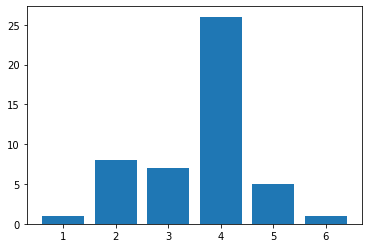

In [48]:
plt.bar(Essays_df['score'], Essays_df['punctuations'])
plt.show()

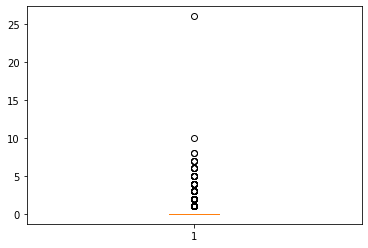

In [49]:
plt.boxplot(Essays_df['punctuations'])
plt.show()

This outlier issue becomes even more aparent when plotting the bar chart and box plot of certain columns. In this intance we can clearly see that there is a very strong outlier (26) that exists far beyond the maximum of our interquatile range. This is also causing our bar chart to skew slightly to the right. These outliers may damage the overall performance of our model as they do not represent the general trend of the data and effect our scaling.

<div>_______________________________________________________________________________________________________________________________</div>

# Winsorize Outliers
As mentioned previously our data contains a large number of outliers that will effect our scaling later when we attempt to scale/normalize our data to a set range. To rectify this, we can winsorize the data in each of our feature columns, reducing the effect of extreme values. (e.g. impute outlier values above a certain threshold to a different value within that threshold).

In [50]:
Win_df = Essays_df.iloc[:, 1:18] #not inclusive of essayid or score

In [51]:
for col in Win_df.columns: 
    Win_df[col] = stats.mstats.winsorize(Win_df[col], limits=0.01)

for each column in our data frame, we winsorize each value above the 1st percentile to a value within the 1st percentile and values below the 99th percentile to a value within the 99th percentile.

In [52]:
Win_df.describe()

,chars,words,commas,apostrophes,punctuations,avg_word_length,sentences,questions,avg_word_sentence,POS,POS/total_words,prompt_words,prompt_words/total_words,synonym_words,synonym_words/total_words,unstemmed,stemmed
count,1332.000000,1332.000000,1332.000000,1332.000000,1332.000000,1332.000000,1332.000000,1332.000000,1332.000000,1332.000000,1332.000000,1332.000000,1332.000000,1332.000000,1332.000000,1332.000000,1332.000000
mean,2096.228228,423.671171,14.602853,8.084084,0.445946,4.941591,19.205706,1.197447,23.592304,419.760480,0.990049,198.289790,0.468816,109.852853,0.263815,469.277027,455.780781
std,840.372890,167.839012,10.669297,5.864522,0.964863,0.215218,8.573001,1.715942,7.327806,166.956204,0.006597,79.785061,0.049850,42.506084,0.037448,158.750698,155.099958
min,389.000000,78.000000,0.000000,2.000000,0.000000,4.414634,3.000000,0.000000,13.000000,75.657658,0.960951,36.000000,0.350575,21.000000,0.175050,105.000000,104.000000
25%,1527.250000,310.000000,7.000000,4.000000,0.000000,4.791679,13.000000,0.000000,19.142857,305.406284,0.987758,144.000000,0.435709,81.000000,0.238423,361.000000,350.750000
50%,2029.500000,411.000000,13.000000,6.000000,0.000000,4.946059,18.000000,1.000000,22.030331,406.982869,0.991572,193.000000,0.465852,107.500000,0.262872,463.000000,448.000000
75%,2613.500000,525.000000,21.000000,11.000000,0.000000,5.092938,24.000000,2.000000,26.048234,520.739458,0.994425,246.000000,0.500000,134.000000,0.288277,581.000000,561.250000
max,4484.000000,921.000000,51.000000,29.000000,5.000000,5.432432,43.000000,8.000000,59.666667,912.993435,0.998792,436.000000,0.603960,238.000000,0.358382,750.000000,750.000000


Here we can see post-winsorization that the max values in each column have been trimmed down to a more reasonable value, reducing the skewness of each features distribution.

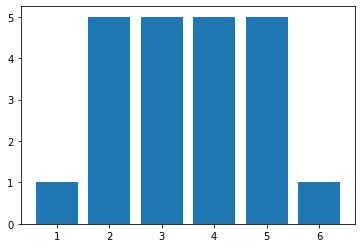

In [53]:
plt.bar(Essays_df['score'], Win_df['punctuations'])
plt.show()

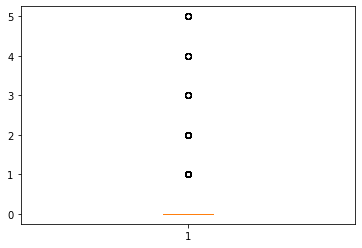

In [54]:
plt.boxplot(Win_df['punctuations'])
plt.show()

While there still exists outliers within our dataset, these are no where near as extreme as the ones we have winsorized. As such, these values can be taken as natural outliers that are reflective of our dataset.

<div>_______________________________________________________________________________________________________________________________</div>

# Section 2 Supervised Learning
In the field of machine learning, methods used to train a predictive model can fall into one of two categories, supervised and unsupervised learning. In supervised learning, a predictor model is trained on a dataset containing both a set of input variables and a set of known output variables. This is known as the concept of 'labelling' or 'labelled data' whereby all data is labelled and inputs are already mapped to the correct output. This allows a model to learn how to predict values from previously unseen data by emulating the mapping function it learnt from the labelled training data. Supervised learning is primarily divided into two categories that being classification problems for discrete output variables and regression problems for continious outputs.

Source: https://www.javatpoint.com/supervised-machine-learning, https://www.ibm.com/cloud/learn/supervised-learning#:~:text=Supervised%20learning%2C%20also%20known%20as,data%20or%20predict%20outcomes%20accurately.

<div>_______________________________________________________________________________________________________________________________</div>

# Creating Train and Test Datasets
It's important that we create seperate datasets for the purposes of machine learning in order to create an effective model. The goal of machine learning is to train a model to effectively generalize a pattern and make accurate predictions based on unseen data. If we were to train and test our model on the entire data set we would likely introduce overfitting into our model. We would also not be able to evaluate our model accurately as it might have developed hyper-specific patterns that allow it to perform well on the data it has seen, but may perform poorly when encountering new data. As such, it is important that we partition our dataset into a training set, used solely for the purpose of constructing and training our model, and a test/validation set used exclusively to evaluate the models performance using data it has never seen before.

Source: https://blog.roboflow.com/train-test-split/

In [55]:
X = Win_df.iloc[:, 0:18].values 
y = Essays_df.iloc[:, 18]   

Here we split the original data into features and labels. We grab the features from the dataset we winsorized previously and assign it to the array X while the label 'score' is obtained from the original dataset and assigned to the array y.

In [56]:
print(X.shape)
print(y.shape)

(1332, 17)
(1332,)


As we can see both arrays have the same number of rows but differing columns.

In [57]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20)

We can then split our X and y arrays into the X_train and X_test datasets and y_train and y_test datasets respectively. Here i have set a test_size of 20%, as such only 20% of the data will be partitioned into our test sets while the remaining 80% will be allocated to our training sets. I have chosen an 80/20 split to provide the model more datapoints to learn from  as our overall dataset is not very large .

In [58]:
counter = Counter(y_train)
for k,v in counter.items():
    per = v / len(y) * 100
    print('Class=%d, n=%d (%.3f%%)' % (k, v, per))

Class=3, n=437 (32.808%)
Class=4, n=486 (36.486%)
Class=5, n=44 (3.303%)
Class=2, n=83 (6.231%)
Class=1, n=13 (0.976%)
Class=6, n=2 (0.150%)


It's worth noting that the distribution of classes/labels in our data set is extremely imbalanced. Just based on our training set, we can see that the top two classes, 3 and 4 ,make up almost 70% of the overall data we for our label 'score'.
This may lead to issues later when attempting to train a model that can effectively learn how to predict each class due to their low frequency in the training set.

<div>_______________________________________________________________________________________________________________________________</div>

# Section 3 Classification
There are two kinds of classification problems, binary and multi-class. Binary classifications are problems whereby the dataset's label can be only assigned to one of two possible classes such as 'yes' or 'no' or 1 and 0. Multi-class classifications are problems where the dataset's label can be assigned to more than two classes, this assignment for example, is a multi-class classification problem as we are attempting to classify an essay into a grade/score from 1 to 6.

<div>_______________________________________________________________________________________________________________________________</div>

# Scaling/Normalising Feature Sets
We will scale our data to a standardized range by removing the mean and scaling to unit variance using sklearns StandardScaler() function. As we saw previously, our feature data was dispersed over a wide variety of ranges, possesing differing shapes and distributions, standardizing our data into a set range helps to improve our models performance as many models tend to perform poorly if the individual features are not arranged in a uniform gaussian distibution.

Source: https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html

In [59]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

<div>_______________________________________________________________________________________________________________________________</div>

# SVM and Kernal Properties
SVMs or Support Vector Machines, are a type of linear supervised learning model that is commonly used to solve classification and regresssion problems. unlike a linear regression, it is capable of seperating both linear and non-linearly seperable datasets by defining an n-dimensional plane through the use of support vectors, which are essentially the data points closest to the plane. This n-dimensional plane, also known as a hyperplane, acts as the decision boundry, classifying datapoints on either side of it as seperate classes, the confidence to which it can classify a datapoint as a member of a certain class is based on how great the distance between the datapoint and the hyperplane is, this distance is known as the margin. As such it is the job of the SVM, to determine the best possible hyperplane in order to maximize this margin and classify data more accurately. Once the svm has determined the appropiate hyperplane to seperate the data, it can then use complicated mathematical functions and transformations to map this decision boundary back to two dimensions. Additionally, SVM's are more robust to outliers as opposed to linear regressions and are capable of being used to predict both discrete and continious variables.

As mentioned prior, SVM's are heavily reliant on these complicated mathematical operations and transformations in order to seperate non linear data which can result in extremely high computational loads depending on the size and complexity of the data set. Hence, we make use of a kernel to cut short the computational load. A kernel is essentially a special function that allows us to compute a linear or non-linear classifier in higher dimensional spaces without needing to excplicitly transform and map our feature space to a higher dimension. This shortcut is known as the "kernel trick" and allows SVM's to compute complicated hyperplanes in high-dimensions with relative ease. Different kernels such as 'linear', 'rbf' and 'sigmoid' kernels use different functions and perform differently when used with different types a datasets. For example, a linear kernel might be able to quickly and accurately seperate a set of linearly seperable data but might struggle when attempting to process non-linear data when compared to a polynomial or rbf kernel.

Source: https://monkeylearn.com/blog/introduction-to-support-vector-machines-svm/#:~:text=How%20Does%20SVM%20Work%3F,-The%20basics%20of&text=A%20support%20vector%20machine%20takes,to%20the%20other%20as%20red, https://towardsdatascience.com/https-medium-com-pupalerushikesh-svm-f4b42800e989#:~:text=SVM%20or%20Support%20Vector%20Machine,separates%20the%20data%20into%20classes, https://www.quora.com/What-are-kernels-in-machine-learning-and-SVM-and-why-do-we-need-them, https://towardsdatascience.com/comparative-study-on-classic-machine-learning-algorithms-24f9ff6ab222

In [60]:
Model = SVC(class_weight ="balanced")

Here i am just initializing my model to the Support Vector Classifier (SVC) from the sklearn.svm module. I am not setting any hyperparameters outside of class_weight = "balanced" as we will determine which hyperparameters are best suited for my data using a gridsearch with K-fold cross validation.

<div>_______________________________________________________________________________________________________________________________</div>

# Exhaustive Gridsearch to Determine Best Model Hyperparameters
Here we will run an exhaustive gridsearch across multiple SVC hyperparameters to determine what kernel, C and gamma are best suited for modelling this dataset. This gridsearch makes use of the concept of cross validation which essentially is the process of splitting a dataset into k-number folds/pairs of training and testing data and returning performance metrics for the model when it is trained and tested on each seperate fold.

In [61]:
grid = [
    {"kernel": ["rbf", "linear"], "gamma": [0.1, 0.01, 0.001, 0.001], "C": [1, 10, 100, 1000]}
]

Here we can set the grid to a nested dictionary of parameters we want to iterate through.

In [62]:
kappa_scorer = make_scorer(cohen_kappa_score, weights="quadratic")
grid_search = GridSearchCV(estimator = Model, param_grid = grid, cv = 5, n_jobs = -1, verbose = 2, scoring = kappa_scorer)
grid_search.fit(X_train, y_train)
print(grid_search.best_score_)
print(grid_search.best_params_)

Fitting 5 folds for each of 32 candidates, totalling 160 fits
0.6632244867182413
{'C': 1, 'gamma': 0.1, 'kernel': 'rbf'}


We make use of the function make_scorer() in order to create our custom scoring metric for the grid search, which in this case will be the quadratic weighted kappa of our model. We then pass the model we previously initialized into the gridsearcher and fit it to our training data. Once it has completey iterated through every possible combination of parameters defined in our grid, we print our highest scoring parameters along with their score. Beyond that the remaining parameters are as follows: cv = number of k-folds (5), n_jobs = number of cpu cores used for this task (-1 meaning all of them), verbose = details the function will print during execution (2 being a brief summary).

In [79]:
weights = {1:68, 2:13, 3:5, 4:5, 5:12, 6:36}
OptimizedModel = SVC(kernel = 'rbf', C = 10, gamma = 0.001, class_weight = weights)
OptimizedModel.fit(X_train, y_train)

SVC(C=10, class_weight={1: 68, 2: 13, 3: 5, 4: 5, 5: 12, 6: 36}, gamma=0.001)

In my case 90% of the time, the best parameters for this particular dataset are an rbf kernel, a C of 10 and a gamma or 0.001. We can then input these hyperparameters into our new OptimizedModel and begin manually tuning our class_weight. This is necesarry as the frequency of classes that appear in this dataset is extremely imbalanced, as such we have to increase the weight of classes that appear less frequently so it will impact the machine learning algorithm more drastically when encountered during training.

In [80]:
print(np.mean(cross_val_score(OptimizedModel, X_train, y_train, cv=10, scoring = kappa_scorer)))

0.6924853539548175


Once again we make use of cross-validation in order to properly evaluate our model. This time we return the mean of 10 k-folds resulting in greater consistency.

<div>_______________________________________________________________________________________________________________________________</div>

# Predictions and Model Evaluation/Metrics
Now that we have our trained model we can begin predicting and validating our data from the test set using different kinds of model evaluation techniques and metrics.

In [81]:
y_pred = OptimizedModel.predict(X_test)
print(y_pred)

[4 4 5 3 3 2 4 2 4 3 4 4 5 3 4 4 4 3 4 3 1 4 2 6 4 4 3 5 3 3 4 4 3 4 4 3 3
 2 4 4 3 4 3 3 3 4 4 4 4 3 4 3 4 4 2 3 3 3 2 4 1 3 2 3 3 5 4 3 3 4 2 4 3 3
 4 3 3 4 4 3 3 1 1 4 4 3 4 3 4 3 3 3 3 3 4 4 5 4 2 3 2 4 3 4 4 3 4 2 2 4 4
 3 3 3 3 3 3 3 4 3 3 4 3 3 4 4 3 3 3 5 4 2 3 4 4 3 3 3 3 3 3 4 3 3 4 4 4 4
 4 4 3 4 3 2 3 2 4 4 3 3 2 3 4 4 4 5 3 2 4 4 4 4 3 4 4 4 3 3 4 4 4 3 4 3 4
 3 3 3 4 4 3 4 4 3 3 2 3 3 3 2 4 3 3 3 3 4 3 4 4 1 3 4 4 3 3 3 4 4 4 3 1 4
 4 3 1 4 3 3 4 4 3 3 4 4 4 2 4 4 4 4 3 3 3 3 2 3 3 3 3 4 1 4 4 4 3 3 3 3 4
 4 3 3 4 3 2 2 3]


In [82]:
confusion_matrix(y_test, y_pred)

array([[ 2,  3,  0,  0,  0,  0],
       [ 5,  9, 13,  0,  0,  0],
       [ 1, 11, 81, 27,  0,  0],
       [ 0,  0, 21, 72,  4,  0],
       [ 0,  0,  2, 10,  3,  1],
       [ 0,  0,  0,  2,  0,  0]], dtype=int64)

The confusion matrix is a summary of all prediction reults within a classification problem. It shows a mixture of True Positives(TP), False Positives(FP), True Negatives(TN) and False Negatives(FN) that have been predicted for any given class. In this case, we have a total of 6 classes, hence we display a 6x6 matrix of how our model has decided to classify each and every essay from our test set. This is important as not only does it allow us to evaluate if our model is making mistakes, but also to visualize how those mistakes and misclassifications are being made. Beyond that, we can also calculate a handful of other important metrics from the confusion matrix such as accuracy, precision, misclassification, sensitivity, specificity and error using the TP, TN, FP, and FN values obtained from the matrix.

Source: https://machinelearningmastery.com/confusion-matrix-machine-learning/#:~:text=A%20confusion%20matrix%20is%20a%20summary%20of%20prediction%20results%20on,key%20to%20the%20confusion%20matrix.

In [83]:
cohen_kappa_score(y_test, y_pred, weights = 'quadratic')

0.6837763519706691

Quadratic Weighted Kappa (QWK) is a type of statistical metric that quantifies the degree of agreement between two raters. Its score can range from -1 to 1 whereby 1 would represent complete and total agreement, -1 would be complete disagreement, and the values in between would denote some varying degree of agreement:

  0  - 0.20   ->  Complete randomness of agreement/no agreement<br>
0.21 - 0.39   ->  Minimal agreement<br>
0.40 - 0.59   ->  Weak agreement<br>
0.60 - 0.79   ->  Moderate agreement<br>
0.80 - 0.90   ->  Strong agreement<br>
0.91 - 0.99   ->  Near perfect agreement<br>

QWK is calculated between a set of of predicted and known values and represents a useful metric for classification when simple metrics such as accuracy are not fully representative of a models performance. In order for a weighted kappa score to be reliable, it is crucial that both raters observed the exact same data and are independant from one another. A good example of this would like judging food at a competition, in order to give a fair evaluation between judges, each judge must taste the same dish(data) and judge the dish independantly from each and other (unbiased).

Source: https://www.kaggle.com/code/aroraaman/quadratic-kappa-metric-explained-in-5-simple-steps/notebook, https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3900052/

In [84]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.25      0.40      0.31         5
           2       0.39      0.33      0.36        27
           3       0.69      0.68      0.68       120
           4       0.65      0.74      0.69        97
           5       0.43      0.19      0.26        16
           6       0.00      0.00      0.00         2

    accuracy                           0.63       267
   macro avg       0.40      0.39      0.38       267
weighted avg       0.62      0.63      0.62       267



The classification report is also another handy tool for determining your models performance. For example, our dataset has an imbalance of classes, thus it would be more appropriate to observe our percision and recall metrics rather than focus on increasing the accuracy of the model. In this case  we would like to maximize our precision in classifying score 3 and 4 essays as they are the most abudant class.

<div>_______________________________________________________________________________________________________________________________</div>

# Section 4 Kaggle Submission Task
Now that we've trained and evaluated or model we can use it to predict and submit our scores to Kaggle.

In [85]:
Kaggle_df = pd.read_csv('FIT1043-Essay-Features-Submission.csv')

In [86]:
X = Kaggle_df.iloc[:, 1:18].values

Here we can read the Essay Features Submission csv file into a dataframe and cast the columns 1 to 17 to an array called X.

In [87]:
sc = StandardScaler()
X = sc.fit_transform(X)

Then we perform the same process of standardizing and scaling the data using StandardScaler so our model can predict the scores more accurately. 

In [88]:
y_pred = OptimizedModel.predict(X)

In [89]:
Submission_df = Kaggle_df.iloc[:, [0]]
Submission_df['score'] = y_pred

Now we can create the dataframe we wish to export and submit to kaggle by grabbing the first column of our Kaggle dataframe containing the essayid column and adding our y predictions as a seperate column called score.

In [90]:
Submission_df

,essayid,score
0,1623,4
1,1143,3
2,660,4
3,1596,4
4,846,4
...,...,...
194,1226,3
195,862,4
196,1562,4
197,1336,3


In [91]:
Submission_df.to_csv (r'C:\Users\brand\Desktop\export_dataframe.csv', index = False, header=True) #exporting df to .csv format

In [92]:
print(y_pred)

[4 3 4 4 4 4 3 3 3 3 3 4 4 3 4 4 4 4 4 3 3 3 4 4 4 4 4 4 4 3 2 4 3 3 4 3 5
 4 3 3 3 4 3 3 1 3 3 4 4 3 2 4 4 4 3 4 4 4 4 4 2 3 3 4 3 3 4 4 3 4 3 3 4 3
 3 3 3 4 4 4 4 3 4 3 4 2 4 4 1 3 3 3 4 3 4 4 4 4 3 3 4 5 2 3 3 4 3 3 5 4 4
 3 4 4 4 3 2 4 2 3 4 4 4 3 2 4 3 5 4 3 4 4 1 3 4 4 3 4 1 4 4 4 4 3 3 4 4 3
 4 4 4 3 4 3 4 3 3 3 3 4 4 3 2 2 4 5 3 3 2 4 3 4 4 3 4 4 4 3 3 5 4 2 4 4 4
 4 3 3 3 3 3 4 3 5 3 4 4 3 3]


Here's a summary of our predictions for this iteration!

<div>_______________________________________________________________________________________________________________________________</div>

# Section 5 Conclusion
In conclusion, we have successfully trained a basic SVM predictor model and gone through the necesarry steps in order to verify and evaluate its performance. In doing so, I have gained a deeper understanding of the data modelling and predictive analysis aspects data science as well as exposure to the practical methods, techniques and libraries used by data professionals across the world in the field of multi-class classification as well as pre-processing imbalanced and noisy datasets. I have also gained experience in aspect such as evaluation techniques, model performance metrics as well as independant model evaluation through Kaggle.

<div>_______________________________________________________________________________________________________________________________</div>